In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [3]:
(x_train, _),(x_test,_)=cifar10.load_data()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce so we will re-download the data.
170500096/170498071 [==============================] - 961s 6us/step


In [4]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
img_chan = x_train.shape[3]

In [5]:
img_dir ='saved_img'
save_dir = os.path.join(os.getcwd(),img_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [8]:
def rgb_to_gray(rgb):
    return np.dot(rgb[...,:3], [0.299,0.587,0.114])

In [9]:
x_train_gray = rgb_to_gray(x_train)
x_test_gray = rgb_to_gray(x_test)

In [10]:
x_train_gray = x_train_gray.astype('float32')/255.0
x_test_gray = x_test_gray.astype('float32')/255.0

In [11]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [12]:
x_train=x_train.reshape(x_train.shape[0], img_rows, img_cols, img_chan)

In [13]:
x_test=x_test.reshape(x_test.shape[0], img_rows, img_cols, img_chan)

In [15]:
x_train_gray=x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)

In [16]:
x_test_gray=x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [17]:
input_shape=(img_rows,img_cols,1)
batch_size=32
kernel_size=3
latent_dim=256
layer_filters = [64,128,256,512]

In [18]:
inputs = Input(shape=input_shape, name='enc_inp')
x=inputs
for filters in layer_filters:
    x=Conv2D(filters = filters, kernel_size=kernel_size, strides=2,activation = 'relu', padding='same')(x)
shape=K.int_shape(x)

In [19]:
x=Flatten()(x)

In [20]:
latent= Dense(latent_dim, name='latent_vector')(x)

In [21]:
encoder= Model(inputs,latent,name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_inp (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 512)         1180160   
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               5245

In [22]:
latent_inputs = Input(shape=(latent_dim,),name='decoder_input')
x=Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x=Reshape((shape[1],shape[2],shape[3]))(x)

In [23]:
for filters in layer_filters[::-1]:
    x=Conv2DTranspose(filters = filters, kernel_size=kernel_size, strides=2,activation = 'relu', padding='same')(x)
outputs=Conv2DTranspose(filters=img_chan,kernel_size=kernel_size, activation = 'sigmoid', padding='same', name='decoder_outp')(x)

In [24]:
decoder= Model(latent_inputs,outputs,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              526336    
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         2359808   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        7379

In [25]:
autoenc=Model(inputs, decoder(encoder(inputs)), name='Autoencoder')
autoenc.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_inp (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 256)               2074368   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         4436611   
Total params: 6,510,979
Trainable params: 6,510,979
Non-trainable params: 0
_________________________________________________________________


In [26]:
save_dir = os.path.join(os.getcwd(),'saved_models')
model_name = 'color_mod.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath=os.path.join(save_dir,model_name)


In [27]:
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),cooldown=0, patience=5, verbose =1, min_lr=0.05e-6)
model_checkpoint= ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1,save_best_only=True)

In [29]:
autoenc.compile(loss='mse',optimizer='adam')
callbacks=[lr_reducer,model_checkpoint]
autoenc.fit(x_train_gray,x_train,validation_data=[x_test_gray,x_test],epochs=30,batch_size=batch_size,callbacks=callbacks)


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
49984/50000 [============================>.] - ETA: 0s - loss: 0.0192
Epoch 00001: val_loss improved from inf to 0.01444, saving model to C:\Users\Souham\Desktop\personal\Untitled Folder\saved_models\color_mod.001.h5
50000/50000 [==============================] - 64s 1ms/sample - loss: 0.0192 - val_loss: 0.0144
Epoch 2/30
49952/50000 [============================>.] - ETA: 0s - loss: 0.0133
Epoch 00002: val_loss improved from 0.01444 to 0.01260, saving model to C:\Users\Souham\Desktop\personal\Untitled Folder\saved_models\color_mod.002.h5
50000/50000 [==============================] - 53s 1ms/sample - loss: 0.0133 - val_loss: 0.0126
Epoch 3/30
49952/50000 [============================>.] - ETA: 0s - loss: 0.0121
Epoch 00003: val_loss did not improve from 0.01260
50000/50000 [==============================] - 53s 1ms/sample - loss: 0.0121 - val_loss: 0.0134
Epoch 4/30
49952/50000 [============================>.] - ETA: 0s - lo

In [59]:
x_decode=autoenc.predict(x_test_gray)

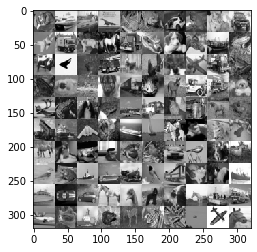

In [64]:
imgsg = x_test_gray[:100]
imgsg= imgsg.reshape((10,10,img_rows,img_cols))
imgsg = np.vstack([np.hstack(i) for i in imgsg])
plt.imshow(imgsg, interpolation='none',cmap='gray')
plt.show()

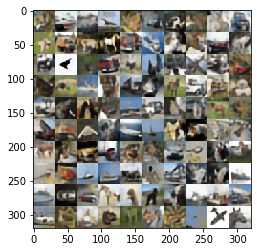

In [65]:
imgs = x_decode[:100]
imgs= imgs.reshape((10,10,img_rows,img_cols,img_chan))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.imshow(imgs, interpolation='none')
plt.show()

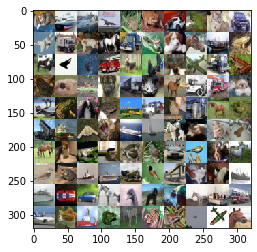

In [66]:
imgsa = x_test[:100]
imgsa= imgsa.reshape((10,10,img_rows,img_cols,img_chan))
imgsa = np.vstack([np.hstack(i) for i in imgsa])
plt.imshow(imgsa, interpolation='none')
plt.show()